# **Individual Differences in *Music Listening* Behaviors**
Lindsay Warrenburg  
lindsay.a.warrenburg@gmail.com  
Final version: December 21, 2020

### This script describes Step 3 of investigating individual differences in lockdown situations and *music listening* behaviors.

- A descriptive analysis of *music listening behavior* is conducted with regard to people in the top 25% and bottom 25% of each of the 6 latent factors of the demographic and personality variables. 
- The analysis primarily compares the means and standard deviations of various musical behaviors across the "High Scorers" (top 25%) and "Low Scorers" (bottom 25%).

In [1]:
import numpy as np, pandas as pd, os, sys, itertools, re, seaborn as sns, warnings, matplotlib.pyplot as plt, statsmodels.api as sm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)
warnings.filterwarnings(action='ignore')
%run Coronavirus_Music_Functions.ipynb

In [2]:
all_data = pd.read_csv('factors_all_data.csv') 
all_data.rename(columns={'Demographics_General_Gender': 'Gender'}, inplace=True)
all_data.shape

(5113, 240)

# Pre-Processing

In [3]:
# reorder columns
id_col = all_data.pop('ID')
country_col = all_data.pop('Country')
gender_col = all_data.pop('Gender')

all_data.insert(0, 'Gender', gender_col)
all_data.insert(0, 'Country', country_col)
all_data.insert(0, 'ID', id_col)

### Only keep participants who completed the *music listening* part of the survey

In the survey, there were four groups of people:
- People who reported *listening to music* during the pandemic
- People who reported *making music* during the pandemic
- People who reported both *listening to* and *making music* during the pandemic
- People who did not *listen to* or *make music* during the pandemic

If people did not listen to music during the pandemic, they were not shown those questions -- the questionnaire skipped music listening questions and went to the next section. Therefore, we cannot use these participants' data in a model of music listening.

In [4]:
# only keep people in 'listening' and 'both listening and making' groups
data = all_data[all_data['Survey Info_Group'].isin(['both','listening only'])].reset_index(drop=True)
data['Survey Info_Group'].value_counts()

both              3003
listening only    1669
Name: Survey Info_Group, dtype: int64

### Make the final dataframe for this analysis

Delete columns not relevant to this analysis:
- Music making columns are tested in a separate script.
- Formats (no one in Germany saw those questions, due to an error)
- Demographics/Personality (instead of the individual columns, we use the factor scores that were created based on these variables)

In [5]:
# get separate dataframes for country and factor scores
country = pd.get_dummies(data['Country'], prefix='Country')
factors = data[['F1','F2','F3','F4','F5','F6']]

In [6]:
# only keep relevant columns
drop_cols = ['F1','F2','F3','F4','F5','F6','Making Music', 'Formats','Survey Info_Group','Country']
col_list = [string for string in data.columns if not any(substring in string for substring in drop_cols)]
data = data[col_list]

data.columns = data.columns.str.replace("Music Listening_", "")

In [7]:
# final df
df = pd.concat([factors, country, data], axis = 1, sort = False).reset_index(drop = True)
df.shape

(4672, 168)

# Individual Differences

### Create labels for people who had factor scores in the top 25% and in the bottom 25%

The groups of "high" and "low" scores is a ***subjective decision***. It was made post-hoc to allow comparisons of musical behaviors among people who differ on the factor scores. Future research should operationalize "high" and "low" scorers more concretely, a priori.

In [8]:
# set cutoff scores for defining 'high' and 'low' scorers
high_cutoff = 75
low_cutoff = 25

f1 = split_into_high_low(df, 'F1', low_cutoff, high_cutoff)
f2 = split_into_high_low(df, 'F2', low_cutoff, high_cutoff)
f3 = split_into_high_low(df, 'F3', low_cutoff, high_cutoff)
f4 = split_into_high_low(df, 'F4', low_cutoff, high_cutoff)
f5 = split_into_high_low(df, 'F5', low_cutoff, high_cutoff)
f6 = split_into_high_low(df, 'F6', low_cutoff, high_cutoff)

### Create a Graph Showing how 'High' and 'Low' Scorers differ in the two Emotion-Related Factors

#### Negative Emotion (Factor 1)

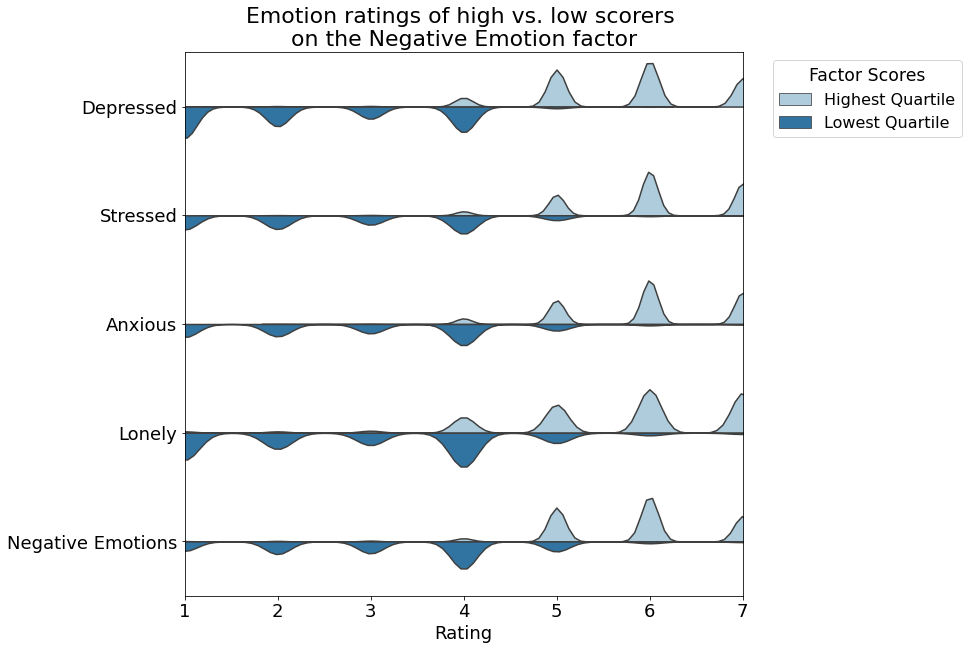

In [37]:
col_name = 'Emotion ratings of high vs. low scorers \non the Negative Emotion factor'

# get variables that load highly on the Negative Emotion factor (from the factor analysis script)
neg = f1[['ID','type','Demographics_Health_Depressed','Demographics_Health_Stressed','Demographics_Health_Anxious',
          'Demographics_Health_Negative Valence','Demographics_Health_Lonely']]
neg.columns = neg.columns.str.replace(r'^.*Health_', '')
neg = neg.rename(columns={'type':col_name,
                          'Negative Valence':'Negative Emotions'})

# condense the df so there is one Rating column and one Affect column that identifies what the emotion variable name is
df_melt = pd.melt(neg, id_vars=['ID',col_name], value_vars=['Depressed','Stressed','Anxious','Lonely','Negative Emotions'],
                  var_name='Affect', value_name='Rating')
df_melt[col_name] = df_melt[col_name].replace({'high':'Highest Quartile','low': 'Lowest Quartile'})

# plot high vs. low scorers
f = plt.figure(figsize=(10,10))
ax = sns.violinplot(x="Rating", y="Affect", hue=col_name, bw=.1, inner=None,
               data=df_melt, palette="Paired", split=True)
plt.title(col_name,fontsize=22)
plt.xlim(1,7)
plt.xlabel('Rating',fontsize=18)
plt.ylabel('')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.rcParams['legend.title_fontsize'] = 'xx-large'
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Factor Scores", prop={'size':16})
f.savefig('images/neg_emotion_factor_scorers.png', dpi=300, bbox_inches = "tight")

#### Positive Emotion (Factor 3)

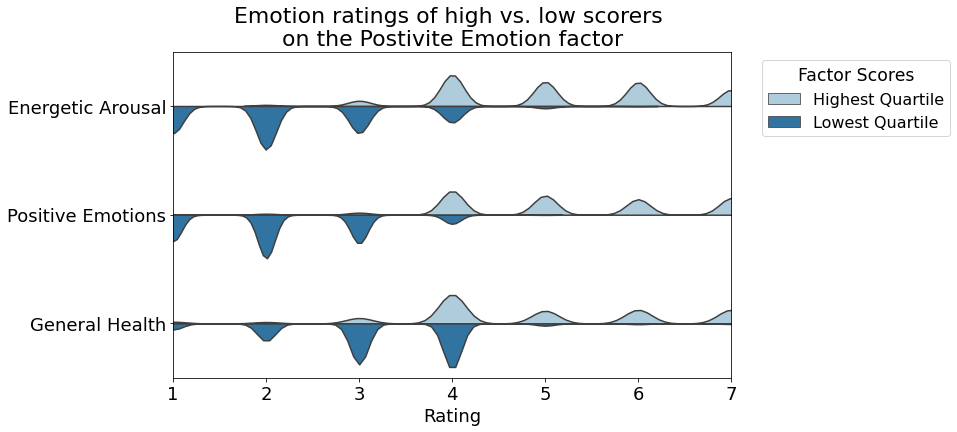

In [31]:
col_name = 'Emotion ratings of high vs. low scorers \non the Postivite Emotion factor'

# get variables that load highly on the Positive Emotion factor (from the factor analysis script)
pos = f3[['ID','type','Demographics_Health_Arousal',
          'Demographics_Health_Positive Valence','Demographics_Health_General Health']]
pos.columns = pos.columns.str.replace(r'^.*Health_', '')
pos = pos.rename(columns={'type':col_name, 'Arousal':'Energetic Arousal',
                          'Positive Valence':'Positive Emotions'})

# condense the df so there is one Rating column and one Affect column that identifies what the emotion variable name is
df_melt = pd.melt(pos, id_vars=['ID',col_name], value_vars=['Energetic Arousal','Positive Emotions','General Health'],
                  var_name='Affect', value_name='Rating')
df_melt[col_name] = df_melt[col_name].replace({'high':'Highest Quartile','low': 'Lowest Quartile'})

# plot high vs. low scorers
f = plt.figure(figsize=(10,6))
ax = sns.violinplot(x="Rating", y="Affect", hue=col_name, bw=.1, inner=None,
               data=df_melt, palette="Paired", split=True)
plt.title(col_name,fontsize=22)
plt.xlim(1,7)
plt.xlabel('Rating',fontsize=18)
plt.ylabel('')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.rcParams['legend.title_fontsize'] = 'xx-large'
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Factor Scores", prop={'size':16})
f.savefig('images/pos_emotion_factor_scorers.png', dpi=300, bbox_inches = "tight")

#### Delete irrelevant columns

In [17]:
for dataframe in [f1,f2,f3,f4,f5,f6]:
    col_list = [c for c in dataframe.columns if c.startswith('Demographics_')]
    dataframe.drop(col_list, axis=1, inplace=True)

### **Factor 1: Changes in Negative Emotions**

- ***Highest factor loadings (absolute value)***: changes in depression (+), stress (+), anxiety (+), negative valence (+), and loneliness (+) during the coronavirus crisis
- ***High scores***: Experiencing *more* negative emotions during the pandemic than before the pandemic
- ***Low scores***: Experiencing *less* negative emotions during the pandemic than before the pandemic

In [12]:
factor1_summary = factor_summary(f1)
cols = [i for i in factor1_summary.index if not i.startswith('Activities')]

factor1_summary.loc[cols,:].round(2)

,Difference_Mean,Difference_SD,High_Mean,High_SD,Low_Mean,Low_SD
Situations_Alone,0.68,-0.01,5.25,1.46,4.57,1.46
Situations_Dining,0.48,0.23,4.38,1.47,3.90,1.24
Situations_Doing Nothing Else,0.61,0.06,5.04,1.45,4.43,1.39
Situations_Evening,0.62,0.10,4.70,1.45,4.08,1.35
Situations_Exercising,0.59,0.05,4.94,1.43,4.35,1.39
Situations_Housework,0.63,0.00,5.09,1.44,4.45,1.43
Situations_Morning,0.50,0.17,4.56,1.51,4.06,1.35
Situations_Other Activities,0.71,0.05,5.04,1.42,4.33,1.37
Situations_Sexual Activity,0.46,0.26,4.35,1.37,3.89,1.11
Situations_Traveling,0.49,0.16,4.60,1.67,4.11,1.51


### **Factor 2: Age**

- ***Highest factor loadings (absolute value)***: Parents (+), students (+), age in years (-), retired (-)
- ***High scores***: Younger individuals
- ***Low scores***: Older individuals

In [13]:
factor2_summary = factor_summary(f2)
cols = [i for i in factor2_summary.index if not i.startswith('Activities')]

factor2_summary.loc[cols,:].round(2)

,Difference_Mean,Difference_SD,High_Mean,High_SD,Low_Mean,Low_SD
Situations_Alone,0.67,0.36,5.03,1.51,4.36,1.16
Situations_Dining,0.04,0.42,3.98,1.36,3.93,0.94
Situations_Doing Nothing Else,0.56,0.46,4.82,1.54,4.26,1.07
Situations_Evening,0.51,0.58,4.45,1.51,3.94,0.93
Situations_Exercising,0.87,0.45,4.88,1.47,4.01,1.02
Situations_Housework,0.49,0.40,4.79,1.49,4.30,1.09
Situations_Morning,0.12,0.48,4.15,1.48,4.03,1.00
Situations_Other Activities,0.58,0.38,4.78,1.43,4.20,1.05
Situations_Sexual Activity,0.08,0.40,4.00,1.24,3.92,0.85
Situations_Traveling,0.28,0.68,4.29,1.70,4.01,1.02


### **Factor 3: Changes in Positive Emotions**

- ***Highest factor loadings (absolute value)***: changes in positive valence (+), energetic arousal (+), and general health (+) during the coronavirus crisis
- ***High scores***: Experiencing *more* positive emotions during the pandemic than before the pandemic
- ***Low scores***: Experiencing *less* positive emotions during the pandemic than before the pandemic

In [14]:
factor3_summary = factor_summary(f3)
cols = [i for i in factor3_summary.index if not i.startswith('Activities')]

factor3_summary.loc[cols,:].round(2)

,Difference_Mean,Difference_SD,High_Mean,High_SD,Low_Mean,Low_SD
Situations_Alone,0.31,0.04,5.09,1.52,4.78,1.48
Situations_Dining,0.63,0.35,4.49,1.54,3.86,1.19
Situations_Doing Nothing Else,0.34,0.12,4.92,1.52,4.58,1.40
Situations_Evening,0.69,0.23,4.78,1.51,4.09,1.28
Situations_Exercising,0.45,0.22,4.92,1.57,4.47,1.35
Situations_Housework,0.32,0.11,4.96,1.54,4.64,1.43
Situations_Morning,0.60,0.32,4.63,1.59,4.03,1.27
Situations_Other Activities,0.36,0.14,4.93,1.52,4.57,1.38
Situations_Sexual Activity,0.55,0.50,4.44,1.50,3.89,1.00
Situations_Traveling,0.65,0.07,4.68,1.63,4.03,1.57


### **Factor 4: Living Situation during the Pandemic**

- ***Highest factor loadings (absolute value)***: Living with a partner (+), living with a child (+), living alone (-)
- ***High scores***: Living with others during the pandemic
- ***Low scores***: Living alone during the pandemic

In [15]:
factor4_summary = factor_summary(f4)
cols = [i for i in factor4_summary.index if not i.startswith('Activities')]

factor4_summary.loc[cols,:].round(2)

,Difference_Mean,Difference_SD,High_Mean,High_SD,Low_Mean,Low_SD
Situations_Alone,0.28,0.04,4.95,1.42,4.67,1.39
Situations_Dining,0.19,0.16,4.19,1.35,4.00,1.19
Situations_Doing Nothing Else,0.35,0.05,4.83,1.41,4.48,1.36
Situations_Evening,0.21,0.16,4.43,1.38,4.21,1.22
Situations_Exercising,0.42,0.09,4.80,1.39,4.37,1.29
Situations_Housework,0.44,0.10,4.88,1.43,4.44,1.33
Situations_Morning,0.32,0.18,4.39,1.41,4.07,1.23
Situations_Other Activities,0.39,0.14,4.80,1.40,4.40,1.26
Situations_Sexual Activity,0.27,0.16,4.17,1.24,3.90,1.08
Situations_Traveling,0.18,0.25,4.31,1.64,4.14,1.38


### **Factor 5: Employment Situation**

- ***Highest factor loadings (absolute value)***: Employed full time (+), retired (-)
- ***High scores***: Employed (pre-pandemic)
- ***Low scores***: Retired (pre-pandemic)

In [16]:
factor5_summary = factor_summary(f5)
cols = [i for i in factor5_summary.index if not i.startswith('Activities')]

factor5_summary.loc[cols,:].round(2)

,Difference_Mean,Difference_SD,High_Mean,High_SD,Low_Mean,Low_SD
Situations_Alone,0.27,0.00,4.88,1.34,4.60,1.34
Situations_Dining,0.35,0.17,4.16,1.24,3.81,1.08
Situations_Doing Nothing Else,0.24,0.04,4.68,1.31,4.44,1.27
Situations_Evening,0.25,0.15,4.34,1.33,4.09,1.18
Situations_Exercising,0.39,0.09,4.62,1.31,4.23,1.22
Situations_Housework,0.28,0.07,4.71,1.34,4.43,1.27
Situations_Morning,0.26,0.11,4.25,1.28,3.99,1.17
Situations_Other Activities,0.18,0.12,4.59,1.31,4.41,1.19
Situations_Sexual Activity,0.18,0.25,4.07,1.15,3.89,0.90
Situations_Traveling,0.24,0.29,4.30,1.54,4.06,1.26


### **Factor 6: City Type During the Pandemic**

- ***Highest factor loadings (absolute value)***: Suburban (+), urban (-)
- ***High scores***: Living in a suburban area during the pandemic
- ***Low scores***: Living in an urban area during the pandemic

In [17]:
factor6_summary = factor_summary(f6)
cols = [i for i in factor6_summary.index if not i.startswith('Activities')]

factor6_summary.loc[cols,:].round(2)

,Difference_Mean,Difference_SD,High_Mean,High_SD,Low_Mean,Low_SD
Situations_Alone,-0.25,-0.19,4.63,1.29,4.89,1.48
Situations_Dining,-0.11,-0.20,3.95,1.12,4.06,1.32
Situations_Doing Nothing Else,-0.19,-0.23,4.47,1.25,4.67,1.48
Situations_Evening,-0.14,-0.21,4.16,1.19,4.29,1.40
Situations_Exercising,-0.25,-0.13,4.34,1.26,4.59,1.39
Situations_Housework,-0.24,-0.17,4.49,1.29,4.72,1.46
Situations_Morning,-0.23,-0.17,4.03,1.21,4.26,1.38
Situations_Other Activities,-0.25,-0.16,4.42,1.25,4.67,1.41
Situations_Sexual Activity,-0.15,-0.22,3.92,1.00,4.07,1.22
Situations_Traveling,-0.27,-0.21,4.01,1.38,4.28,1.59
